# Exploratory Data Analysis (EDA) and Feature Engineering

This notebook performs EDA on the Malicious URL Detection dataset and implements feature engineering with an extended set of features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from urllib.parse import urlparse

# Set plot style
sns.set(style="whitegrid")

## 1. Load and Inspect Data

In [2]:
file_path = "../data/raw/malicious_phish.csv"
import os

if os.path.exists(file_path):
    print("Good to go!")
else:
    print("File doesn't exist..")

Good to go!


In [3]:
# Load dataset
df = pd.read_csv(filepath_or_buffer=file_path)

# Display first few rows
print("Dataset Head:")
display(df.head())

# Dataset Info
print("\nDataset Info:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Class distribution
print("\nClass Distribution:")
print(df['type'].value_counts())

Dataset Head:


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB
None

Missing Values:
url     0
type    0
dtype: int64

Class Distribution:
type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64


## 2. Feature Engineering

We will extract the following features:
- `url_length`, `hostname_length`
- `count_letters`, `count_digits`
- Special char counts: `@`, `?`, `-`, `=`, `.`, `#`, `%`, `+`, `$`, `!`, `*`, `,`, `/`
- `count_www`
- `has_ip`
- `abnormal_url`
- `short_url`
- `https`
- `count_dir`
- `count_embed_domain`
- `fd_length`
- `tld_length`
- `suspicious`

In [4]:
def get_url_length(url):
    return len(url)

def get_hostname_length(url):
    return len(urlparse(url).netloc)

def get_count_letters(url):
    return sum(c.isalpha() for c in url)

def get_count_digits(url):
    return sum(c.isdigit() for c in url)

def get_count_special_char(url, char):
    return url.count(char)

def get_count_www(url):
    return url.count('www')

def get_has_ip(url):
    # Regex for IPv4
    match = re.search(r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\/)|'  # IPv4
                      r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)' # IPv4 in hexadecimal
                      r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url) # Ipv6
    if match:
        return 1
    else:
        return 1 if re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', url) else 0

def get_abnormal_url(url):
    # Heuristic: if hostname is not in url (which is weird) or maybe if whois fails (can't do here)
    # Let's use a simple heuristic: if the URL has no hostname
    hostname = urlparse(url).netloc
    if hostname:
        return 0
    return 1

def get_short_url(url):
    shortening_services = r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|' \
                          r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|' \
                          r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|' \
                          r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|' \
                          r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|' \
                          r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|' \
                          r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|' \
                          r'tr\.im|link\.zip\.net'
    match = re.search(shortening_services, url, flags=re.IGNORECASE)
    return 1 if match else 0

def get_https(url):
    return 1 if urlparse(url).scheme == 'https' else 0

def get_count_dir(url):
    path = urlparse(url).path
    return path.count('/')

def get_count_embed_domain(url):
    return max(0, url.count('http') - 1)

def get_fd_length(url):
    path = urlparse(url).path
    try:
        return len(path.split('/')[1])
    except IndexError:
        return 0

def get_tld_length(url):
    try:
        return len(urlparse(url).netloc.split('.')[-1])
    except:
        return 0

def get_suspicious(url):
    keywords = ['login', 'update', 'free', 'paypal', 'secure', 'account', 'banking', 'confirm', 'signin', 'verify']
    return 1 if any(keyword in url.lower() for keyword in keywords) else 0

# Apply features
print("Extracting features... This may take a moment.")
df['url_length'] = df['url'].apply(get_url_length)
df['hostname_length'] = df['url'].apply(get_hostname_length)
df['count_letters'] = df['url'].apply(get_count_letters)
df['count_digits'] = df['url'].apply(get_count_digits)
df['count_@'] = df['url'].apply(lambda x: get_count_special_char(x, '@'))
df['count_?'] = df['url'].apply(lambda x: get_count_special_char(x, '?'))
df['count_-'] = df['url'].apply(lambda x: get_count_special_char(x, '-'))
df['count_='] = df['url'].apply(lambda x: get_count_special_char(x, '='))
df['count_.'] = df['url'].apply(lambda x: get_count_special_char(x, '.'))
df['count_#'] = df['url'].apply(lambda x: get_count_special_char(x, '#'))
df['count_%'] = df['url'].apply(lambda x: get_count_special_char(x, '%'))
df['count_+'] = df['url'].apply(lambda x: get_count_special_char(x, '+'))
df['count_$'] = df['url'].apply(lambda x: get_count_special_char(x, '$'))
df['count_!'] = df['url'].apply(lambda x: get_count_special_char(x, '!'))
df['count_*'] = df['url'].apply(lambda x: get_count_special_char(x, '*'))
df['count_,'] = df['url'].apply(lambda x: get_count_special_char(x, ','))
df['count_slashes'] = df['url'].apply(lambda x: get_count_special_char(x, '/'))
df['count_www'] = df['url'].apply(get_count_www)
df['has_ip'] = df['url'].apply(get_has_ip)
df['abnormal_url'] = df['url'].apply(get_abnormal_url)
df['short_url'] = df['url'].apply(get_short_url)
df['https'] = df['url'].apply(get_https)
df['count_dir'] = df['url'].apply(get_count_dir)
df['count_embed_domain'] = df['url'].apply(get_count_embed_domain)
df['fd_length'] = df['url'].apply(get_fd_length)
df['tld_length'] = df['url'].apply(get_tld_length)
df['suspicious'] = df['url'].apply(get_suspicious)

print("Feature extraction complete.")
display(df.head())

Extracting features... This may take a moment.
Feature extraction complete.


,url,type,url_length,hostname_length,count_letters,count_digits,count_@,count_?,count_-,count_=,...,count_www,has_ip,abnormal_url,short_url,https,count_dir,count_embed_domain,fd_length,tld_length,suspicious
0,br-icloud.com.br,phishing,16,0,13,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,29,1,0,0,0,0,...,0,0,1,0,0,2,0,5,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,25,1,0,0,0,0,...,0,0,1,0,0,3,0,7,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,21,63,7,0,1,1,4,...,1,0,0,0,0,1,0,9,2,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,23,199,22,0,1,1,3,...,0,0,0,0,0,1,0,9,3,0


In [5]:
# Dataset Info
print("\nDataset Info:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Class distribution
print("\nClass Distribution:")
print(df['type'].value_counts())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   url                 651191 non-null  object
 1   type                651191 non-null  object
 2   url_length          651191 non-null  int64 
 3   hostname_length     651191 non-null  int64 
 4   count_letters       651191 non-null  int64 
 5   count_digits        651191 non-null  int64 
 6   count_@             651191 non-null  int64 
 7   count_?             651191 non-null  int64 
 8   count_-             651191 non-null  int64 
 9   count_=             651191 non-null  int64 
 10  count_.             651191 non-null  int64 
 11  count_#             651191 non-null  int64 
 12  count_%             651191 non-null  int64 
 13  count_+             651191 non-null  int64 
 14  count_$             651191 non-null  int64 
 15  count_!             651191 non-null 

## 3. Visualization

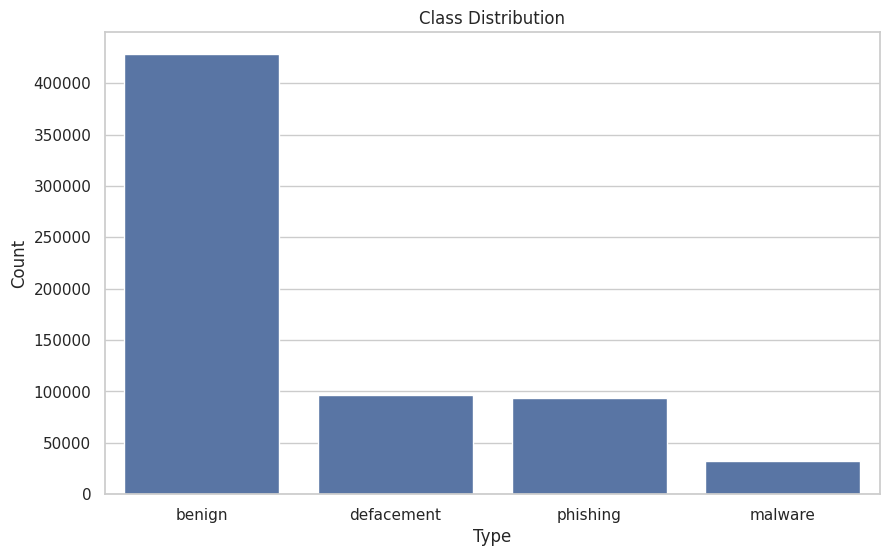

In [6]:
# Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=df, order=df['type'].value_counts().index)
plt.title('Class Distribution')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

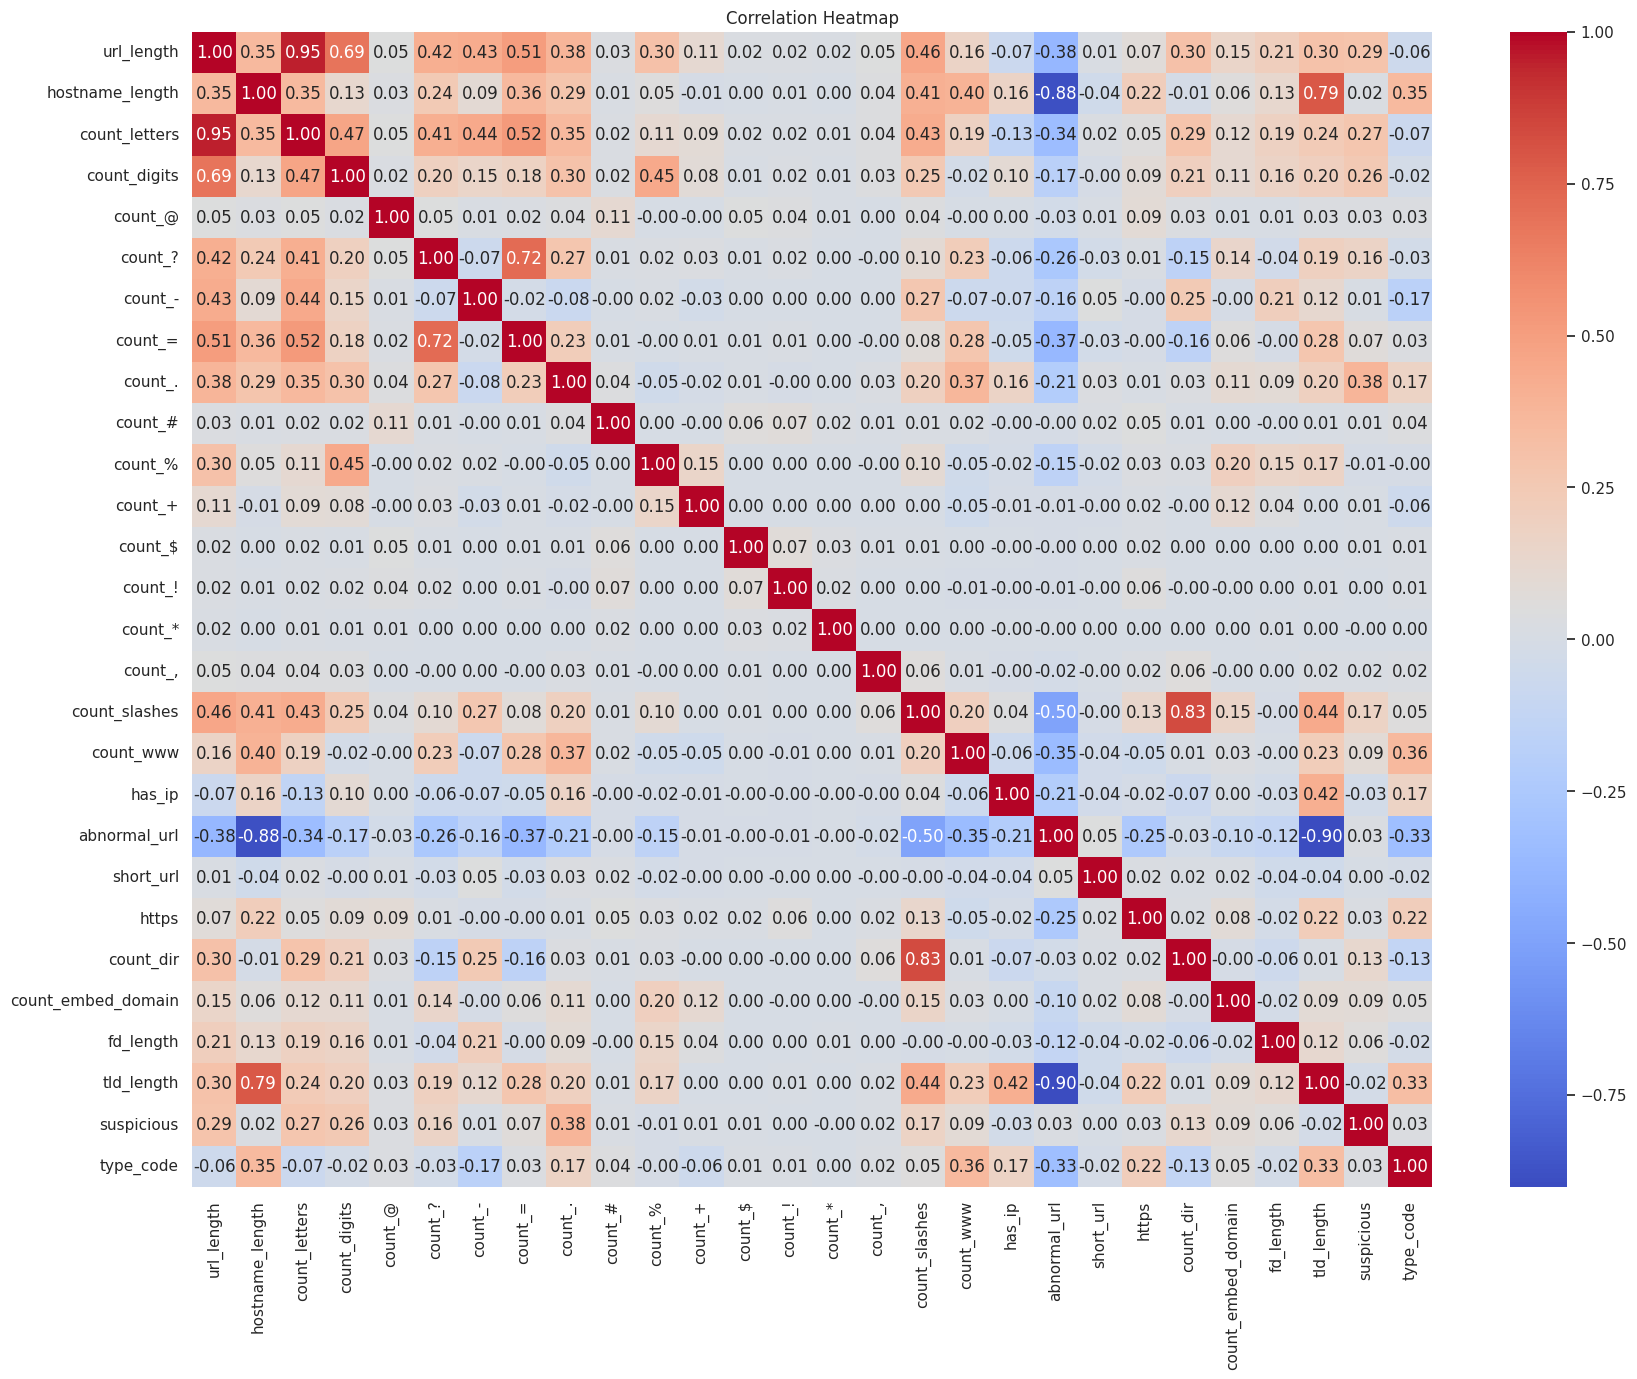

In [7]:
# Encode 'type' for correlation analysis
df['type_code'] = df['type'].astype('category').cat.codes

# Correlation Heatmap
plt.figure(figsize=(20, 15))
numerical_cols = ['url_length', 'hostname_length', 'count_letters', 'count_digits', 
                  'count_@', 'count_?', 'count_-', 'count_=', 'count_.', 'count_#', 
                  'count_%', 'count_+', 'count_$', 'count_!', 'count_*', 'count_,', 
                  'count_slashes', 'count_www', 'has_ip', 'abnormal_url', 'short_url', 
                  'https', 'count_dir', 'count_embed_domain', 'fd_length', 'tld_length', 
                  'suspicious', 'type_code']
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

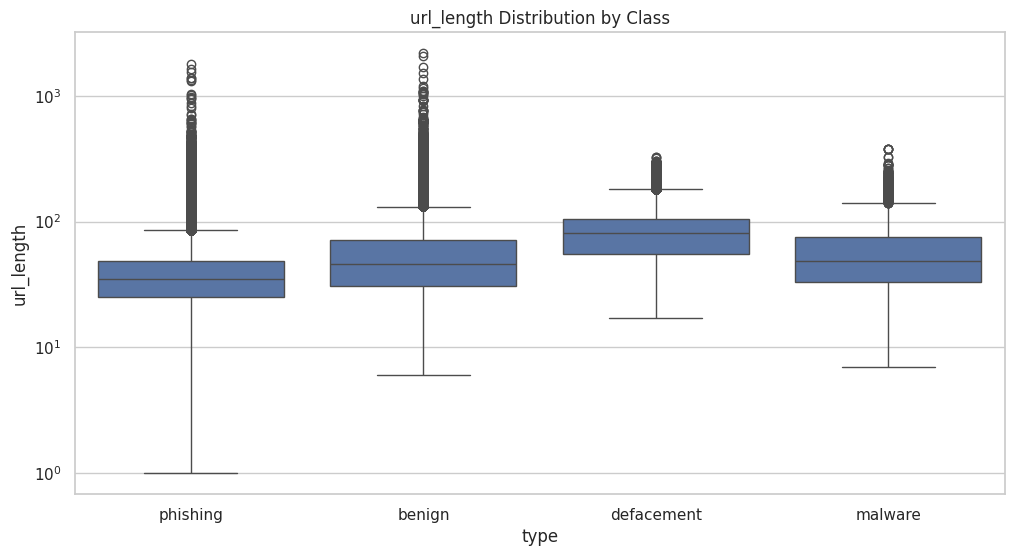

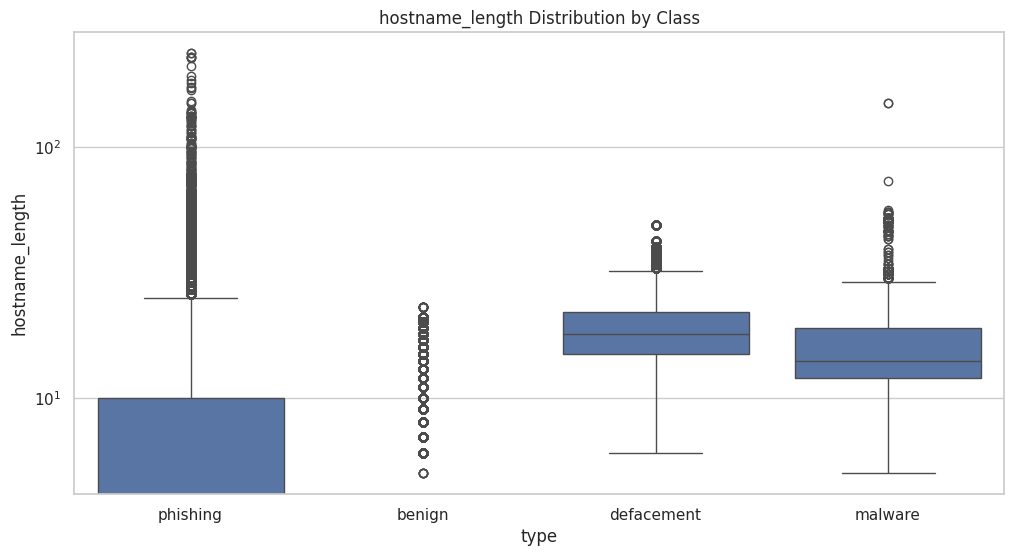

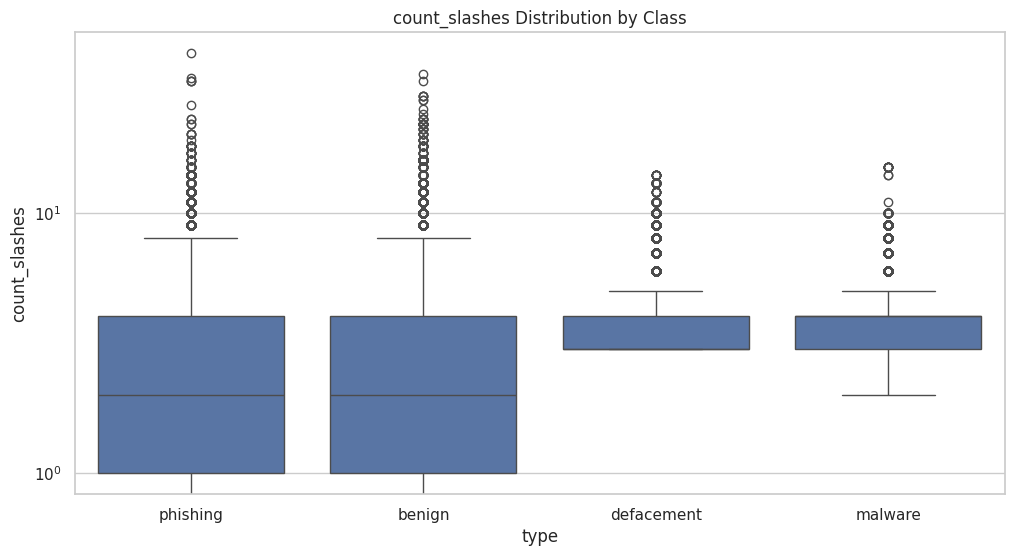

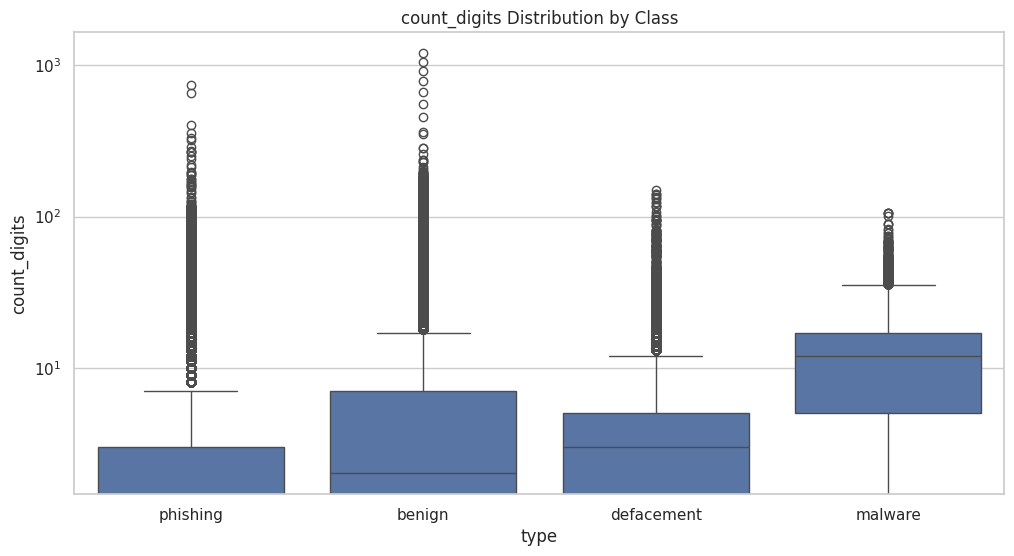

In [8]:
# Boxplots for key features
features_to_plot = ['url_length', 'hostname_length', 'count_slashes', 'count_digits']

for feature in features_to_plot:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='type', y=feature, data=df)
    plt.title(f'{feature} Distribution by Class')
    plt.yscale('log') # Log scale for better visualization of skewed data
    plt.show()

## 4. Save Processed Data (Optional)
We can save the processed dataframe with features for model training.

In [9]:
df.to_csv('../data/processed/malicious_phish_featured_fm_notebook.csv', index=False)
print("Processed data saved.")

Processed data saved.
